Neurono mokymui naudoti stochastinį gradientinį nusileidimą ir sigmoidinį neuroną.

In [8]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Duomenų failo apdorojimas:
1) Klasių vardų pakeitimas reikšmėmis 0 arba 1.
2) id pašalinimas iš breast-cancer-wisconsin.data failo
3) Duomenų atskyrimas į mokymo ir testavimo rinkinius sąntykiu 80:20 atitinkamai.

In [9]:
# duomenų failo apdorojimas. 1 dalis

# Iris-versicolor -> 0
# Iris-virginica -> 1

with open("data/iris.data", "r") as file:
    lines = file.readlines()

with open("data/iris_chg.data", "w") as output_file:
    for line in lines:
        if "Iris-versicolor" in line:
            line = line.replace("Iris-versicolor", "0")
        elif "Iris-virginica" in line:
            line = line.replace("Iris-virginica", "1")
        output_file.write(line)

# 2 -> 0 (nepiktybinis navikas)
# 4 -> 1 (piktybinis navikas)

with open("data/breast-cancer-wisconsin.data", "r") as file:
    lines = file.readlines()

with open("data/breast-cancer-wisconsin_chg.data", "w") as output_file:
    for line in lines:
        parts = line.strip().split(',')
        if len(parts) > 1:
            if parts[-1] == "2":
                parts[-1] = "0"
            elif parts[-1] == "4":
                parts[-1] = "1"
            new_line = ','.join(parts) + '\n'
            output_file.write(new_line)

In [10]:
# duomenų failo apdorojimas. 2 dalis

with open("data/breast-cancer-wisconsin_chg.data", 'r') as f:
    lines = f.readlines()

with open("data/breast-cancer-wisconsin_chg2.data", 'w') as f:
    for line in lines:
        data = line.strip().split(',')
        f.write(','.join(data[1:]) + '\n')


In [11]:
# duomenų failo apdorojimas. 3 dalis
def split_data(original_file, train_file, test_file):
    data = pd.read_csv(original_file, header=None)
    train, test = train_test_split(data, test_size=0.2)
    train.to_csv(train_file, index=False, header=False)
    test.to_csv(test_file, index=False, header=False)

split_data("data/iris_chg.data", "data/iris/iris_train.data", "data/iris/iris_test.data")
split_data("data/breast-cancer-wisconsin_chg2.data", "data/bc/bc_train.data", "data/bc/bc_test.data")

# pašalinama paskutinioji (tuščia) failo eilutė
for filename in ["data/iris/iris_train.data", "data/iris/iris_test.data", "data/bc/bc_train.data","data/bc/bc_test.data"]:
    with open(filename, "rb+") as filehandle:
        filehandle.seek(-2, os.SEEK_END)
        filehandle.truncate()


Aprašomas sigmoidinis dirbtinis neuronas.

In [12]:
class ArtificialNeuron:
    """
    ArtificialNeuron Klasė realizuojanti dirbtinį neuroną.
    """

    def __init__(self):
        """
        __init__ metodas, šiuo metu nepriskiriame pradinių svorių ir poslinkio.
        """
        self.weights = None
        self.bias = None

    def activate(self, inputs):
        """
        activate metodas sumuoja svorių ir įėjimų sandaugas ir prideda poslinkio vertę, grąžinama numatoma klasė.
        """
        weighted_sum = np.dot(inputs, self.weights) + self.bias
        output = self.sigmoid(weighted_sum)
        return output

    def sigmoid(self, x):
        """
        sigmoid metodas naudojamas activate funkcijoje, tam, kad apibrėžtų išeities reikšmę pagal logistinę funkciją.
        """
        return 1 / (1 + np.exp(-x))

    def train(self, training_file, learning_rate, epochs):
        """
        train metodas apmoko dirbtinį neuroną naudojant stochastinį gradientinį nusileidimą.
        """
        # nustatomas svorių skaičius
        weight_number = 0
        with open(training_file, 'r') as f:
            line = f.readline()
            weight_number = line.count(",")
        
        # inicializuojami svoriai ir poslinkis
        self.weights = [0] * weight_number
        self.bias = 0

        # apmokomas neuronas
        errors = []
        accuracies = []
        for epoch in range(epochs):
            total_error = 0
            correct_guesses = 0
            total_guesses = 0
            with open(training_file, 'r') as file:
                for line in file:
                    parts = line.strip().split(',')
                    inputs = [float(part) for part in parts[:-1]]  # inputs pvz.: [6.8, 2.8, 4.8, 1.4]
                    inputs = np.array(inputs)
                    target = float(parts[-1])  # target pvz.: 1.0

                    prediction = self.activate(inputs)
                    error = target - prediction

                    self.weights -= learning_rate * (prediction - target) * prediction * (1 - prediction) * inputs
                    self.bias -= learning_rate * (prediction - target) * prediction * (1 - prediction)

                    total_error += error

                    total_guesses += 1
                    if round(prediction) == target:
                        correct_guesses += 1
            errors.append(total_error)
            accuracy = correct_guesses / total_guesses
            accuracies.append(accuracy)
            print(f"Epocha Nr. {epoch+1}. Gauta paklaida: {total_error}")
            print(f"Tikslumas: {accuracy}")

        # atvaizduojame klaidos grafiką
        plt.plot(range(epochs), errors)
        plt.xlabel('Epochos')
        plt.ylabel('Klaida')
        plt.show()

    def test(self, test_file):
        """
        test metodas leidžia įvertinti modelio tikslumą su testavimo duomenimis.
        """
        total_squared_error = 0
        total_samples = 0

        correct_guesses = 0
        total_guesses = 0

        with open(test_file, 'r') as file:
            for line in file:
                parts = line.strip().split(',')
                inputs = [float(part) for part in parts[:-1]]
                inputs = np.array(inputs)
                target = float(parts[-1])

                prediction = self.activate(inputs)
                
                squared_error = (target - prediction) ** 2
                total_squared_error += squared_error
                total_samples += 1

                total_guesses += 1
                if round(prediction) == target:
                    correct_guesses += 1
                
                print("Spėjimas: " + str(round(prediction)) + ", Tikroji klasė: " + str(target))


        mse = total_squared_error / (2 * total_samples)
        print(f"Gauta paklaida: {mse}")
        print(f"Tikslumas: {correct_guesses/total_guesses}")

        print(self.weights)
        print(self.bias)


Epocha Nr. 1. Gauta paklaida: -101.74889761936257
Tikslumas: 0.7967032967032966
Epocha Nr. 2. Gauta paklaida: -77.84722024342078
Tikslumas: 0.9065934065934066
Epocha Nr. 3. Gauta paklaida: -68.09424743060697
Tikslumas: 0.9157509157509157
Epocha Nr. 4. Gauta paklaida: -62.0354112144093
Tikslumas: 0.9212454212454212
Epocha Nr. 5. Gauta paklaida: -57.803210596124295
Tikslumas: 0.9230769230769231
Epocha Nr. 6. Gauta paklaida: -54.69148133872549
Tikslumas: 0.924908424908425
Epocha Nr. 7. Gauta paklaida: -52.33283264416983
Tikslumas: 0.9267399267399268
Epocha Nr. 8. Gauta paklaida: -50.50216267159526
Tikslumas: 0.9285714285714286
Epocha Nr. 9. Gauta paklaida: -49.04977514804133
Tikslumas: 0.9304029304029304
Epocha Nr. 10. Gauta paklaida: -47.87228839542319
Tikslumas: 0.9322344322344323
Epocha Nr. 11. Gauta paklaida: -46.89699733902222
Tikslumas: 0.9358974358974359
Epocha Nr. 12. Gauta paklaida: -46.072070666166674
Tikslumas: 0.9377289377289377
Epocha Nr. 13. Gauta paklaida: -45.3597899864113

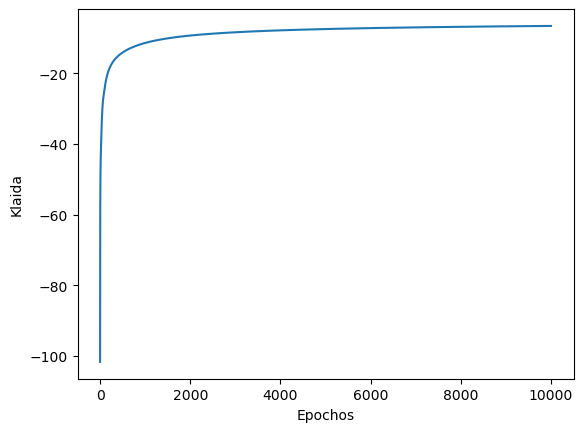

Spėjimas: 0, Tikroji klasė: 0.0
Spėjimas: 1, Tikroji klasė: 1.0
Spėjimas: 0, Tikroji klasė: 0.0
Spėjimas: 1, Tikroji klasė: 1.0
Spėjimas: 0, Tikroji klasė: 0.0
Spėjimas: 0, Tikroji klasė: 0.0
Spėjimas: 0, Tikroji klasė: 0.0
Spėjimas: 0, Tikroji klasė: 0.0
Spėjimas: 1, Tikroji klasė: 1.0
Spėjimas: 1, Tikroji klasė: 1.0
Spėjimas: 1, Tikroji klasė: 1.0
Spėjimas: 0, Tikroji klasė: 0.0
Spėjimas: 1, Tikroji klasė: 1.0
Spėjimas: 0, Tikroji klasė: 0.0
Spėjimas: 0, Tikroji klasė: 0.0
Spėjimas: 0, Tikroji klasė: 0.0
Spėjimas: 1, Tikroji klasė: 1.0
Spėjimas: 0, Tikroji klasė: 0.0
Spėjimas: 1, Tikroji klasė: 1.0
Spėjimas: 1, Tikroji klasė: 1.0
Spėjimas: 0, Tikroji klasė: 0.0
Spėjimas: 1, Tikroji klasė: 1.0
Spėjimas: 0, Tikroji klasė: 0.0
Spėjimas: 0, Tikroji klasė: 0.0
Spėjimas: 0, Tikroji klasė: 0.0
Spėjimas: 0, Tikroji klasė: 0.0
Spėjimas: 1, Tikroji klasė: 1.0
Spėjimas: 1, Tikroji klasė: 1.0
Spėjimas: 1, Tikroji klasė: 1.0
Spėjimas: 1, Tikroji klasė: 1.0
Spėjimas: 0, Tikroji klasė: 0.0
Spėjimas

In [13]:
neuron1 = ArtificialNeuron()
neuron1.train("data/bc/bc_train.data", 0.01, 10000) # čia keičiamas mokymosi greitis, epochų skaičius
neuron1.test("data/bc/bc_test.data")

Epocha Nr. 1. Gauta paklaida: -1.8963642594575014
Tikslumas: 0.55
Epocha Nr. 2. Gauta paklaida: -2.891092537612958
Tikslumas: 0.5625
Epocha Nr. 3. Gauta paklaida: -2.8466366506098137
Tikslumas: 0.5625
Epocha Nr. 4. Gauta paklaida: -2.7787399299797375
Tikslumas: 0.575
Epocha Nr. 5. Gauta paklaida: -2.713604709720462
Tikslumas: 0.5875
Epocha Nr. 6. Gauta paklaida: -2.651659412533295
Tikslumas: 0.5875
Epocha Nr. 7. Gauta paklaida: -2.5927105010826823
Tikslumas: 0.6125
Epocha Nr. 8. Gauta paklaida: -2.536567094587075
Tikslumas: 0.65
Epocha Nr. 9. Gauta paklaida: -2.483053792630055
Tikslumas: 0.6625
Epocha Nr. 10. Gauta paklaida: -2.432009351901554
Tikslumas: 0.7
Epocha Nr. 11. Gauta paklaida: -2.3832852352941027
Tikslumas: 0.7125
Epocha Nr. 12. Gauta paklaida: -2.3367443235838725
Tikslumas: 0.7375
Epocha Nr. 13. Gauta paklaida: -2.2922597773046407
Tikslumas: 0.7625
Epocha Nr. 14. Gauta paklaida: -2.2497140317358677
Tikslumas: 0.7625
Epocha Nr. 15. Gauta paklaida: -2.208997909419864
Tikslum

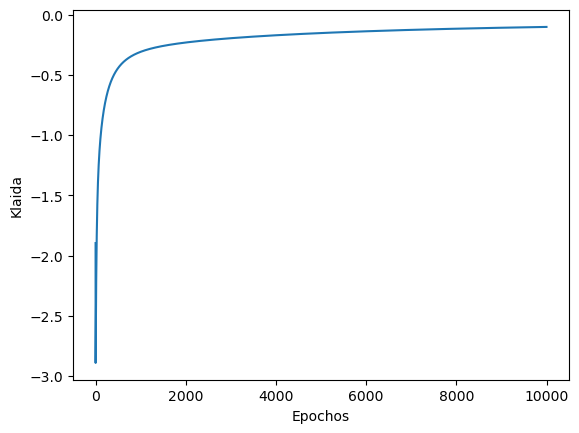

Spėjimas: 1, Tikroji klasė: 1.0
Spėjimas: 1, Tikroji klasė: 1.0
Spėjimas: 0, Tikroji klasė: 0.0
Spėjimas: 1, Tikroji klasė: 1.0
Spėjimas: 1, Tikroji klasė: 1.0
Spėjimas: 1, Tikroji klasė: 1.0
Spėjimas: 1, Tikroji klasė: 1.0
Spėjimas: 0, Tikroji klasė: 0.0
Spėjimas: 1, Tikroji klasė: 1.0
Spėjimas: 0, Tikroji klasė: 0.0
Spėjimas: 0, Tikroji klasė: 0.0
Spėjimas: 0, Tikroji klasė: 0.0
Spėjimas: 0, Tikroji klasė: 0.0
Spėjimas: 1, Tikroji klasė: 0.0
Spėjimas: 1, Tikroji klasė: 1.0
Spėjimas: 0, Tikroji klasė: 0.0
Spėjimas: 1, Tikroji klasė: 1.0
Spėjimas: 0, Tikroji klasė: 0.0
Spėjimas: 0, Tikroji klasė: 0.0
Spėjimas: 1, Tikroji klasė: 1.0
Gauta paklaida: 0.029626127714474988
Tikslumas: 0.95
[-4.31823526 -4.1915452   6.21356776  7.75207854]
-4.500023017443272


In [14]:
neuron2 = ArtificialNeuron()
neuron2.train("data/iris/iris_train.data", 0.01, 10000) # čia keičiamas mokymosi greitis, epochų skaičius
neuron2.test("data/iris/iris_test.data")